In [1]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data import get_rotated_mnist, get_mnist_ood
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import MNIST
from collections import defaultdict


In [2]:
params = pickle.load(open("../checkpoints/MNIST/LeNet_MNIST_0_params.pickle", "rb"))['params']
proj_samples = pickle.load(open("../checkpoints/posterior_MNIST/1000iters_30samples_seed0_params.pickle", "rb"))['posterior_samples']

In [3]:
proj_samples.keys()

dict_keys(['params'])

In [4]:
model = LeNet(output_dim=10, activation="tanh")
model_fn = model.apply

### R-MNIST

In [20]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    _, _, test_loader = get_rotated_mnist(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, proj_samples, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    # params = params_dict['params']
    _, _, test_loader = get_rotated_mnist(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_map.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 0


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9787, nll: 1014.9467, acc: 0.9720, brier: 0.0447, ece: 0.0508, mce: 0.7130


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 1


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9585, nll: 2447.1821, acc: 0.9283, brier: 0.1079, ece: 0.0901, mce: 0.6160


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 2


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9013, nll: 9771.9648, acc: 0.7708, brier: 0.3654, ece: 0.1967, mce: 0.7708


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 3


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8248, nll: 54327.2969, acc: 0.2711, brier: 1.2322, ece: 0.5348, mce: 0.7643


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 4


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8086, nll: 84313.7734, acc: 0.1109, brier: 1.5087, ece: 0.6679, mce: 0.8846


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 5


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8103, nll: 81818.8359, acc: 0.1440, brier: 1.4467, ece: 0.6421, mce: 0.8761


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 6


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8274, nll: 72509.9219, acc: 0.2561, brier: 1.2632, ece: 0.5479, mce: 0.7615


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 7


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8838, nll: 71433.3750, acc: 0.3392, brier: 1.1800, ece: 0.5202, mce: 0.7629


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import pandas as pd
metrics_dict = ['conf', 'nll', 'acc', 'brier', 'ece', 'mce']
method_list = ["Projected laplace",  "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "MAP":metrics_map}
df_data = {metric: ["{:.3f}".format(method_dict[dic][1][metric]) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


In [ ]:
metrics_lr[0]['nll']

Array(1015.03876, dtype=float32)

In [ ]:
metrics_map[0]['nll']

Array(1014.94666, dtype=float32)

In [ ]:
df

,conf,nll,acc,brier,ece,mce
Projected laplace,0.959,2447.452,0.928,0.108,0.090,0.707
MAP,0.959,2447.182,0.928,0.108,0.090,0.616


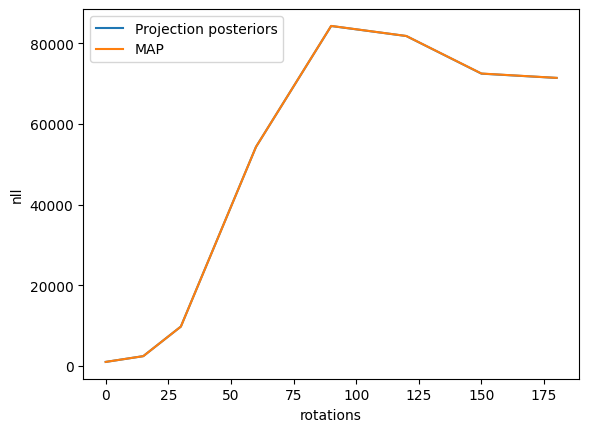

In [ ]:
uq_metric = 'nll'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Projection posteriors")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

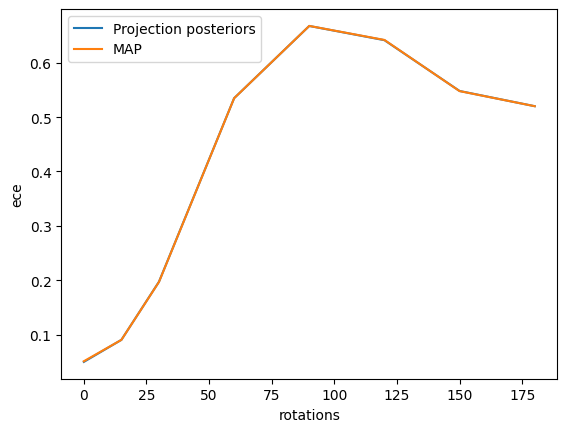

In [ ]:
uq_metric = 'ece'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Projection posteriors")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

In [ ]:
ood_score = all_y_var.sum(axis=-1)


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS, SpectralEmbedding

In [ ]:
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')

In [ ]:
train_loader, _, test_loader = get_rotated_mnist(0, data_path="/dtu/p1/hroy/data", download=True, batch_size=500, n_samples_per_class=500)
train_batch = next(iter(train_loader))['image']
test_batch = next(iter(test_loader))['image']
train_transformed = embedding.fit_transform(train_batch.reshape(500, -1))
test_transformed = embedding.fit_transform(test_batch.reshape(500, -1))
ood_loader, _, _ = get_rotated_mnist(180, data_path="/dtu/p1/hroy/data", download=True, batch_size=500, n_samples_per_class=500)
ood_batch = next(iter(ood_loader))['image']
ood_transformed = embedding.fit_transform(ood_batch.reshape(500, -1))

/dtu/p1/hroy/projected-bayes/src/data/mnist.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

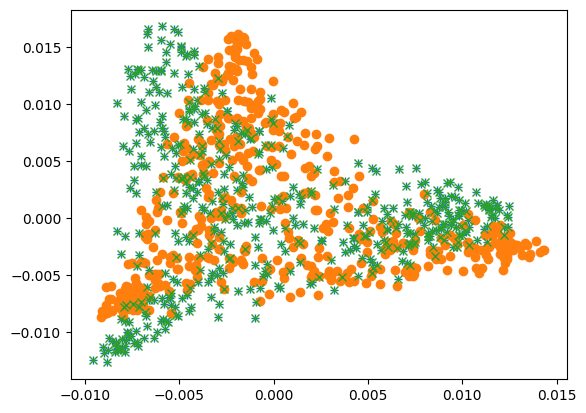

In [ ]:
plt.plot(train_transformed[:, 0], train_transformed[:, 1], '+')
plt.plot(test_transformed[:, 0], test_transformed[:, 1], 'o')
plt.plot(ood_transformed[:, 0], ood_transformed[:, 1], 'x')


In [ ]:
ood_transformed[0]

array([0.01446453, 0.02683621])

In [ ]:
train_transformed[0]

array([0.01446438, 0.02681839])

### OOD MNIST

In [5]:
proj_samples_new = jax.vmap(lambda sample: jax.tree_map(lambda x, y: (x - y) * 100 + y, sample, params))(proj_samples)

In [6]:
import tree_math as tm
print("Mean distance:", jax.vmap(lambda x: (tm.Vector(x) - tm.Vector(params)) @ (tm.Vector(x) - tm.Vector(params))/(tm.Vector(params) @ tm.Vector(params)))(proj_samples).mean())


Mean distance: 0.00012285302


In [7]:
print("Mean distance:", jax.vmap(lambda x: (tm.Vector(x) - tm.Vector(params)) @ (tm.Vector(x) - tm.Vector(params))/(tm.Vector(params) @ tm.Vector(params)))(proj_samples_new).mean())


Mean distance: 1.2285298


In [8]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "KMNIST"]#, 210, 240, 270, 300, 330, 345, 360]
var_dict = {}
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    _, train_loader = get_mnist_ood(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(train_loader, proj_samples_new, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, train_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    var_dict[id] = all_y_var
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: MNIST
conf: 0.7849, nll: 321.1360, acc: 0.9660


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: FMNIST
conf: 0.3908, nll: 3357.2983, acc: 0.0940, auroc: 0.9579, fpr95: 0.2080


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: KMNIST
conf: 0.5048, nll: 4270.7808, acc: 0.0460, auroc: 0.8687, fpr95: 0.4940


In [9]:
from sklearn.metrics import roc_auc_score
import numpy as np
def auroc(scores_id, scores_ood):
    labels = np.zeros(len(scores_id) + len(scores_ood), dtype="int32")
    labels[len(scores_id) :] = 1
    scores = np.concatenate([scores_id, scores_ood])
    return roc_auc_score(labels, scores)

In [11]:
id_score = var_dict["MNIST"].mean(axis=-1)
ood_score = var_dict["KMNIST"].mean(axis=-1)
auroc(id_score, ood_score)

0.8670439999999999

In [50]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "KMNIST"]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    train_loader, _ = get_mnist_ood(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(train_loader, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, train_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: MNIST
conf: 0.9799, nll: 445.4957, acc: 0.9700


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: FMNIST
conf: 0.8404, nll: 31070.6758, acc: 0.0913, auroc: 0.9025, fpr95: 0.5753


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: KMNIST
conf: 0.8204, nll: 42856.7344, acc: 0.0593, auroc: 0.8734, fpr95: 0.5158


In [ ]:
train_loader, _ = get_mnist_ood("KMNIST", data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)

100%|██████████| 18165135/18165135 [00:37<00:00, 486025.29it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/train-images-idx3-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 125855.02it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/train-labels-idx1-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:04<00:00, 615938.71it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 16061956.98it/s]

Extracting /dtu/p1/hroy/data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



In [ ]:
train_loader, _ = get_mnist_ood("EMNIST", data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)

KeyboardInterrupt: 